In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
from price import *
from kalman import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import dates

(CVXPY) May 04 02:35:00 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) May 04 02:35:00 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


## Import Data

In [2]:
# Import data
df = pd.read_csv('data/stock_price.csv', index_col = 0, header=[0,1])
sp500 = pd.read_csv('data/sp500.csv')

Calculate actual return matrix

In [3]:
close_price = df[['Adj Close']]
close_price.columns = close_price.columns.droplevel(0)
volume = df[['Volume']]
volume.columns = volume.columns.droplevel(0)

actual_R_mat = close_price.pct_change()
actual_R_mat = actual_R_mat[1:]
return_matrix = close_price.pct_change().shift(-1)

Calculate predicted return matrix

In [4]:
rol_kal = pd.read_csv('pred_return/rolling_kalman_pure.csv', index_col = 0)
aolma = pd.read_csv('pred_return/aolma.csv', index_col = 0)
ema = pd.read_csv('pred_return/ema.csv', index_col = 0)
sma = pd.read_csv('pred_return/sma.csv', index_col = 0)
old_kal = pd.read_csv('pred_return/old_kalman.csv', index_col = 0)
regression = pd.read_csv('pred_return/regression.csv', index_col = 0)

In [ ]:
train_period = 0.2

In [ ]:
# # Prediction using (old) Kalman Filter
# res1 = pd.DataFrame()
# res2 = pd.DataFrame()
# for fid in tqdm(close_price.columns):
# #     print(fid)
#     temp_close = close_price[fid]
#     temp_volume = volume[fid]
#     data = pd.DataFrame({'target':temp_close.shift(-1)/temp_close-1,'return':temp_close/temp_close.shift()-1,'return_vol':temp_volume/temp_volume.shift()-1})
#     data.index = temp_close.index.values
#     temp_data = data.copy()
#     a = pd.DataFrame({fid:calc_kalman(temp_data,train_period)})
#     res1 = pd.concat([res1, a], axis = 1)
#     temp_data = data.copy()
#     a = pd.DataFrame({fid:calc_kalman_multi(temp_data,train_period)})
#     res2 = pd.concat([res2, a], axis = 1)
#     tempa = np.sign(res1[fid])
#     index0 = tempa.dropna().index
#     tempa = np.sign(res1[fid])[index0]
#     tempb = np.sign(res2[fid])[index0]
#     tempc = np.sign(return_matrix[fid][index0])

## Optimization Model

In [5]:
def NPM(r, his_r, x_tilde, theta, c):
    '''
    param r [ndarray]: vector of predicted return at period t
    param his_r [ndarray]: 2d vector of return for the past W periods; his_r[i][j] = price 
    param x_tilde [ndarray]: investment weights at the end of period t-1
    param theta [float]: acceptable risk level in the range of (0, 1), smaller theta could lead to infeasible solution
    param c [float]: transacion cost in the range of (0, 1)

    '''
    M = len(r) # Number of assets in the portfolio
    W = len(his_r) # Number of recents prices used to measure risk
    
    # Define variables
    u = cp.Variable(M)
    v = cp.Variable(M)
    d = cp.Variable(W)
    g = cp.Variable(W)
    
    # Define Objective
    objective = cp.Maximize(r @ x_tilde + (r - c/2) @ u - (r + c/2) @ v)
    
    # Define constraints
    constraints = [cp.sum(u - v) == 0,
                    -(u - v + x_tilde) <= 0,
                    u - v + x_tilde <= 1,
                    u >= 0, v >= 0, d >= 0, g >= 0]
    
    constraints += [cp.sum(d + g) <= W * theta]
    for j in range(W):
#         print('day', -1-j, np.sum(r - his_r[-1-j]))
        constraints += [(his_r[-1-j] - r) @ u - (his_r[-1-j] - r) @ v - d[j] <= (r - his_r[-1-j]) @ x_tilde,
                        (r - his_r[-1-j]) @ u - (r - his_r[-1-j]) @ v - g[j] <= (his_r[-1-j] - r) @ x_tilde]
        
    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose = False, solver='ECOS_BB')
    if problem.status != cp.OPTIMAL:
        print('problem status', problem.status)
#     constraints_value = [constraint.value for constraint in constraints]
#     print(constraints_value)
        
    return problem, u.value, v.value, d.value, g.value

Algorithm

In [ ]:
pred_R_mat = aolma
weight_mat = []
assets = close_price.columns
actual_R_mat = actual_R_mat 
N = len(pred_R_mat)
num_his = num_his # Number of historical days
init_weight = np.ones(len(assets)) / len(assets) # Start with uniform weight
theta = theta # Risk level
c = c # Transaction Cost
start_day = pred_R_mat.iloc[:, 1].first_valid_index()
start_day = pred_R_mat.index.get_loc(start_day)
start_day += num_his
w = init_weight
for t in tqdm(range(start_day,N)):
    # In the paper, return is defined as pt/pt-1, so we should +1
    predicted_return = np.array((pred_R_mat+1).iloc[t][assets])
    historial_w_actual_returns = (actual_R_mat+1).iloc[t - num_his : t, :][assets]
    historial_w_actual_returns = historial_w_actual_returns.values
    problem, u, v, d, g = NPM(predicted_return, historial_w_actual_returns, w, theta, c)
    w = w + u - v
    weight_mat.append(w)

Analyze the strategy

In [ ]:
signal = pd.DataFrame(np.array(weight_mat), columns = assets, index = pred_R_mat.index[start_day : N])
signal

In [ ]:
# Visualize the weight vector changes over time
signal.plot(figsize=(20, 4));
plt.legend(signal.columns, loc='best', bbox_to_anchor=(1, 1.5));
plt.xlabel('Date')
plt.ylabel('Weight')

In [ ]:
# Benchmark - buy-and-hold
benchmark = actual_R_mat.copy()
benchmark['yield'] = benchmark.apply(lambda x: x.mean(), axis = 1)
benchmark['netvalue'] = benchmark['yield'].cumsum() + 1
benchmark.reset_index(inplace = True)
benchmark['Date'] = pd.to_datetime(benchmark['Date'])

In [ ]:
result = signal*return_matrix
result['yield'] = result.apply(lambda x: x.sum(), axis = 1)
result['netvalue'] = result['yield'].cumsum() + 1
# result['netvalue'] = (result['yield']+1).cumprod()
result['draw'] = np.maximum.accumulate(result['netvalue']) - result['netvalue']
result.reset_index(inplace = True)
result['Date'] = pd.to_datetime(result['index'])
result['draw'] = (result['netvalue']-np.maximum.accumulate(result['netvalue']))
index_j = np.argmax(np.maximum.accumulate(result['netvalue']) - result['netvalue'])  # 结束位置
index_i = np.argmax(result['netvalue'][:index_j])  # 开始位置
index_dif = (result.Date[index_j] -  result.Date[index_i]).days
b = pd.to_datetime(result.Date.values[0])
e = pd.to_datetime(result.Date.values[-1])
years = (e-b).days/252
turnover = np.sum(signal.diff().abs().sum(axis = 1)[1:])
costs = c/2 * np.concatenate((np.zeros(len(result.netvalue) - len(signal)+1), signal.diff().abs().sum(axis = 1)[1:]), axis = 0)
anyield = ((result.netvalue - costs).iloc[-1]-1) / years
maxdraw = np.min(result['draw'])
sharpe = round(result['yield'].mean()/result['yield'].std()*(np.sqrt(252)),4)
calmar = anyield/(-1*maxdraw)
print('maxdraw', -1 * maxdraw)
print('sharpe', sharpe)
print('calmar', calmar)

In [ ]:
# return_matrix
target = (return_matrix['AAPL'] + return_matrix['NVDA'])/2
a = target.cumsum() + 1 

In [ ]:
sp500['Date'] = pd.to_datetime(sp500['Date'])

fig = plt.figure()
axis = fig.add_subplot(1, 1, 1)
axis.plot(result.Date,result.netvalue - costs, color = 'green', label = 'strategy')
axis.plot(benchmark.Date,benchmark.netvalue, color = 'red', label = 'benchmark')
axis.plot(sp500.Date,sp500.Close/sp500.Close.iloc[0], color = 'blue', label = 'sp500')
# axis.plot(result.Date,a, color = 'pink', label = '5050')

axis.plot([result.Date[index_i], result.Date[index_j]], [result['netvalue'][index_i], result['netvalue'][index_j]], 'o', color="r", markersize=5)
axis.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m'))  #設置x軸主刻度顯示格式（日期）
axis.xaxis.set_major_locator(dates.MonthLocator(interval = 12))
for label in axis.get_xticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment('right')
axis.set_title('anyield:'+str(round(anyield,3))+'_maxdraw:'+str(round(maxdraw,4))+'_sharpe:'+str(round(sharpe,3))+'_days:'+str(index_dif))
plt.xlabel('time')
plt.ylabel('netvalue')
plt.legend()
plt.show()

In [6]:
def algo(method, c = 0.0008, num_his = 5, theta = 0.5):

    if method == "rolling_kalman":
        pred_R_mat = rol_kal
    elif method == "aolma":
        pred_R_mat = aolma
    elif method == "ema":
        pred_R_mat = ema
    elif method == "sma":
        pred_R_mat = sma
    elif method == "kalman":
        pred_R_mat = old_kal
    elif method == "regression":
        pred_R_mat = regression
    
    df = pd.read_csv('data/stock_price.csv', index_col = 0, header=[0,1])
    sp500 = pd.read_csv('data/sp500.csv')
    
    close_price = df[['Adj Close']]
    close_price.columns = close_price.columns.droplevel(0)
#     volume = df[['Volume']]
#     volume.columns = volume.columns.droplevel(0)
    actual_R_mat = close_price.pct_change()
    actual_R_mat = actual_R_mat[1:]
    return_matrix = close_price.pct_change().shift(-1)
        
    weight_mat = []
    assets = close_price.columns
    actual_R_mat = actual_R_mat 
    N = len(pred_R_mat)
    num_his = num_his # Number of historical days
    init_weight = np.ones(len(assets)) / len(assets) # Start with uniform weight
    theta = theta # Risk level
    c = c # Transaction Cost
    start_day = pred_R_mat.iloc[:, 1].first_valid_index()
    start_day = pred_R_mat.index.get_loc(start_day)
    if method != "kalman":
        start_day += num_his

    w = init_weight
    for t in tqdm(range(start_day,N)):
        # In the paper, return is defined as pt/pt-1, so we should +1
        predicted_return = np.array((pred_R_mat+1).iloc[t][assets])
        historial_w_actual_returns = (actual_R_mat+1).iloc[t - num_his : t, :][assets]
        historial_w_actual_returns = historial_w_actual_returns.values
        problem, u, v, d, g = NPM(predicted_return, historial_w_actual_returns, w, theta, c)
        w = w + u - v
        weight_mat.append(w)
        
    signal = pd.DataFrame(np.array(weight_mat), columns = assets, index = pred_R_mat.index[start_day : N])
    result = signal*return_matrix
    result['yield'] = result.apply(lambda x: x.sum(), axis = 1)
    result['netvalue'] = result['yield'].cumsum() + 1
    # result['netvalue'] = (result['yield']+1).cumprod()
    result['draw'] = np.maximum.accumulate(result['netvalue']) - result['netvalue']
    result.reset_index(inplace = True)
    result['Date'] = pd.to_datetime(result['index'])
    result['draw'] = (result['netvalue']-np.maximum.accumulate(result['netvalue']))
    index_j = np.argmax(np.maximum.accumulate(result['netvalue']) - result['netvalue'])  # 结束位置
    index_i = np.argmax(result['netvalue'][:index_j])  # 开始位置
    index_dif = (result.Date[index_j] -  result.Date[index_i]).days
    b = pd.to_datetime(result.Date.values[0])
    e = pd.to_datetime(result.Date.values[-1])
    years = (e-b).days/252
    turnover = np.sum(signal.diff().abs().sum(axis = 1)[1:])
    costs = c/2 * np.concatenate((np.zeros(len(result.netvalue) - len(signal)+1), signal.diff().abs().sum(axis = 1)[1:]), axis = 0)
    anyield = ((result.netvalue - costs).iloc[-1]-1) / years
    maxdraw = np.min(result['draw'])
    sharpe = round(result['yield'].mean()/result['yield'].std()*(np.sqrt(252)),4)
    calmar = anyield/(-1*maxdraw)

    cum_return = result['netvalue'].iloc[-1]

    return cum_return, maxdraw, sharpe, calmar

### Robustness Experiment

1. Vary Transaction Cost c in between [0.0003, 0.0008, 0.0013, 0.0018, 0.0023, 0.0028]

In [7]:
methods = ["aolma", "ema", "sma", "kalman", "regression", "rolling_kalman"]
cum_return_lst = {}
sharpe_lst = {}
calmar_lst = {}
for method in methods:
    cum_return_lst[method] = []
    sharpe_lst[method] = []
    calmar_lst[method] = []
    cs = [0.0003, 0.0008, 0.0013, 0.0018, 0.0023, 0.0028]
    for cost in cs:
        cum_return, maxdraw, sharpe, calmar = algo(method, c = cost, num_his = 5, theta = 0.5)
        cum_return_lst[method].append(cum_return)
        sharpe_lst[method].append(sharpe)
        calmar_lst[method].append(calmar)

100%|██████████| 2491/2491 [1:10:43<00:00,  1.70s/it]  


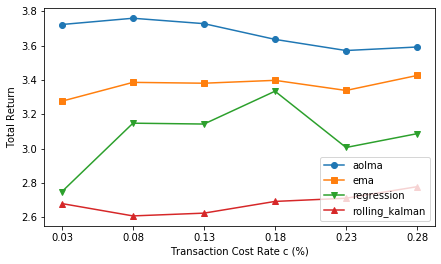

In [45]:
markers = ['o', 's', 'v', '^', 'd', '*']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7, 4))

for i in range(len(methods)):
    ax.plot(cs, cum_return_lst[methods[i]], marker=markers[i], linestyle='-', label = methods[i])

ax.set_xticks(cs)
ax.set_xticklabels((np.array(cs)*100).round(2));

ax.set_ylabel('Total Return')
ax.set_xlabel('Transaction Cost Rate c (%)')
ax.legend(loc ='lower right');

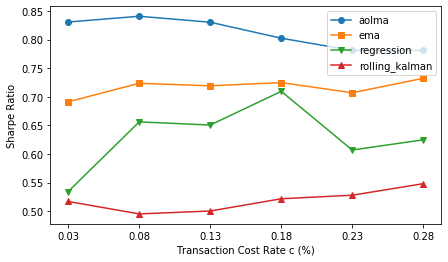

In [44]:
markers = ['o', 's', 'v', '^', 'd', '*']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7, 4))

for i in range(len(methods)):
    ax.plot(cs, sharpe_lst[methods[i]], marker=markers[i], linestyle='-', label = methods[i])

ax.set_xticks(cs)
ax.set_xticklabels((np.array(cs)*100).round(2));

ax.set_ylabel('Sharpe Ratio')
ax.set_xlabel('Transaction Cost Rate c (%)')
ax.legend(loc = 'best');

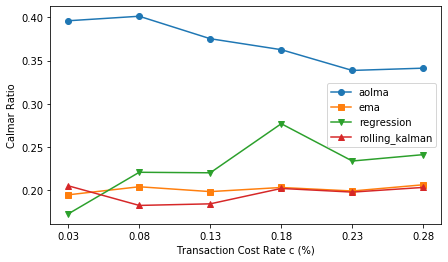

In [46]:
markers = ['o', 's', 'v', '^', 'd', '*']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7, 4))

for i in range(len(methods)):
    ax.plot(cs, calmar_lst[methods[i]], marker=markers[i], linestyle='-', label = methods[i])

ax.set_xticks(cs)
ax.set_xticklabels((np.array(cs)*100).round(2));

ax.set_ylabel('Calmar Ratio')
ax.set_xlabel('Transaction Cost Rate c (%)')
ax.legend(loc = 'best');

2. Vary Num Hist between [5, 10, 15, 20, 25]

In [36]:
methods = ["aolma", "ema", "regression", "rolling_kalman"]
cum_return_lst2 = {}
max_draw_lst2 = {}
sharpe_lst2 = {}
calmar_lst2 = {}
for method in methods:
    cum_return_lst2[method] = []
    sharpe_lst2[method] = []
    calmar_lst2[method] = []
    max_draw_lst2[method] = []
    num_hiss = [5, 10, 15, 20, 25]
    for num_his in num_hiss:
        cum_return, maxdraw, sharpe, calmar = algo(method, c = 0.0008, num_his = num_his, theta = 0.1)
        cum_return_lst2[method].append(cum_return)
        sharpe_lst2[method].append(sharpe)
        calmar_lst2[method].append(calmar)
        max_draw_lst2[method].append(maxdraw)

100%|██████████| 2471/2471 [07:11<00:00,  5.73it/s]


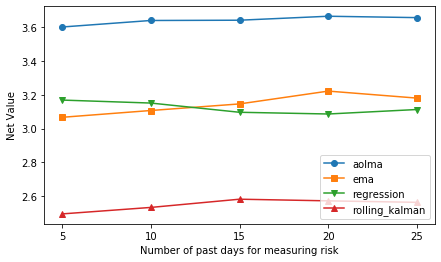

In [47]:
markers = ['o', 's', 'v', '^', 'd', '*']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7, 4))

for i in range(len(methods)):
    ax.plot(num_hiss, cum_return_lst2[methods[i]], marker=markers[i], linestyle='-', label = methods[i])

ax.set_xticks(num_hiss)
ax.set_xticklabels(num_hiss);

ax.set_ylabel('Net Value')
ax.set_xlabel('Number of past days for measuring risk')
ax.legend(loc ='lower right');

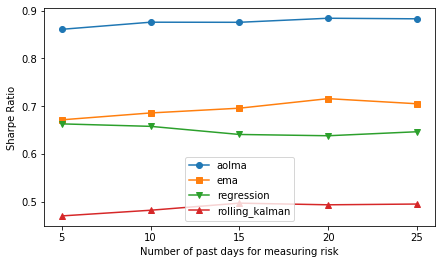

In [48]:
markers = ['o', 's', 'v', '^', 'd', '*']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7, 4))

for i in range(len(methods)):
    ax.plot(num_hiss, sharpe_lst2[methods[i]], marker=markers[i], linestyle='-', label = methods[i])


ax.set_xticks(num_hiss)
ax.set_xticklabels(num_hiss);

ax.set_ylabel('Sharpe Ratio')
ax.set_xlabel('Number of past days for measuring risk')
ax.legend(loc = 'best');

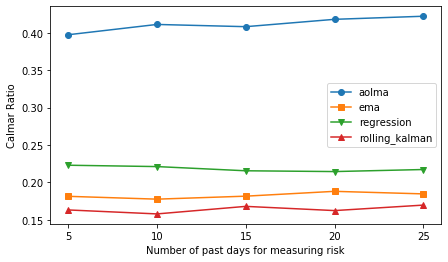

In [49]:
markers = ['o', 's', 'v', '^', 'd', '*']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7, 4))

for i in range(len(methods)):
    ax.plot(num_hiss, calmar_lst2[methods[i]], marker=markers[i], linestyle='-', label = methods[i])

ax.set_xticks(num_hiss)
ax.set_xticklabels(num_hiss);

ax.set_ylabel('Calmar Ratio')
ax.set_xlabel('Number of past days for measuring risk')
ax.legend(loc = 'best');

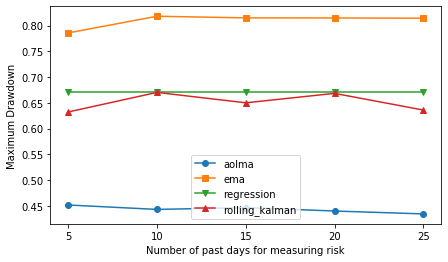

In [55]:
markers = ['o', 's', 'v', '^', 'd', '*']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7, 4))

for i in range(len(methods)):
    ax.plot(num_hiss, -1 * np.array(max_draw_lst2[methods[i]]), marker=markers[i], linestyle='-', label = methods[i])

ax.set_xticks(num_hiss)
ax.set_xticklabels(num_hiss);

ax.set_ylabel('Maximum Drawdown')
ax.set_xlabel('Number of past days for measuring risk')
ax.legend(loc = 'best');

3. Vary theta between [0.05, 0.2, 0.35, 0.5, 1, 5]

In [15]:
methods = ["sma", "aolma", "ema", "kalman", "regression", "rolling_kalman"]
cum_return_lst3 = {}
max_draw_lst3 = {}
sharpe_lst3 = {}
calmar_lst3 = {}
for method in methods:
    cum_return_lst3[method] = []
    sharpe_lst3[method] = []
    calmar_lst3[method] = []
    max_draw_lst3[method] = []
    thetas = [0.1, 0.2, 0.3, 0.5, 1, 5]
    for theta in thetas:
        cum_return, maxdraw, sharpe, calmar = algo(method, c = 0.0008, num_his = 5, theta = theta)
        cum_return_lst3[method].append(cum_return)
        sharpe_lst3[method].append(sharpe)
        calmar_lst3[method].append(calmar)
        max_draw_lst3[method].append(maxdraw)

100%|██████████| 2491/2491 [02:33<00:00, 16.24it/s]


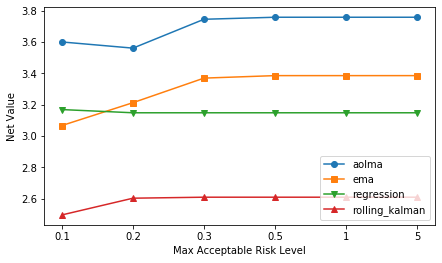

In [51]:
markers = ['o', 's', 'v', '^', 'd', '*']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7, 4))

for i in range(len(methods)):
    ax.plot(np.arange(6), cum_return_lst3[methods[i]], marker=markers[i], linestyle='-', label = methods[i])

# ax.set_xticks(thetas)
ax.set_xticklabels([0, 0.1, 0.2, 0.3, 0.5, 1, 5]);

ax.set_ylabel('Net Value')
ax.set_xlabel('Max Acceptable Risk Level')
ax.legend(loc ='lower right');

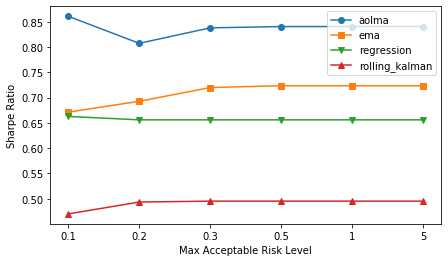

In [52]:
markers = ['o', 's', 'v', '^', 'd', '*']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7, 4))

for i in range(len(methods)):
    ax.plot(np.arange(6), sharpe_lst3[methods[i]], marker=markers[i], linestyle='-', label = methods[i])

ax.set_xticklabels([0, 0.1, 0.2, 0.3, 0.5, 1, 5]);

ax.set_ylabel('Sharpe Ratio')
ax.set_xlabel('Max Acceptable Risk Level')
ax.legend(loc = 'best');

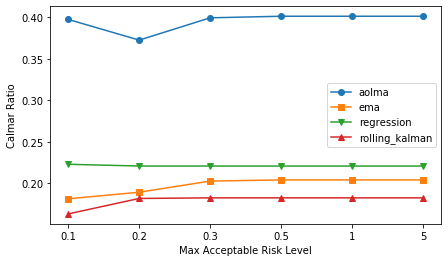

In [53]:
markers = ['o', 's', 'v', '^', 'd', '*']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7, 4))

for i in range(len(methods)):
    ax.plot(np.arange(6), calmar_lst3[methods[i]], marker=markers[i], linestyle='-', label = methods[i])

ax.set_xticklabels([0, 0.1, 0.2, 0.3, 0.5, 1, 5]);

ax.set_ylabel('Calmar Ratio')
ax.set_xlabel('Max Acceptable Risk Level')
ax.legend(loc = 'best');

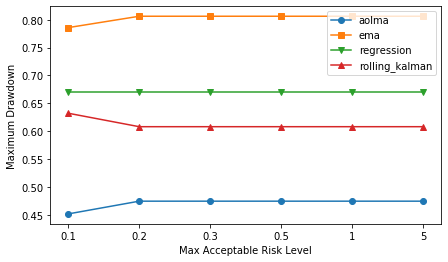

In [54]:
markers = ['o', 's', 'v', '^', 'd', '*']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7, 4))

for i in range(len(methods)):
    ax.plot(np.arange(6), -1 * np.array(max_draw_lst3[methods[i]]), marker=markers[i], linestyle='-', label = methods[i])

ax.set_xticklabels([0, 0.1, 0.2, 0.3, 0.5, 1, 5]);

ax.set_ylabel('Maximum Drawdown')
ax.set_xlabel('Max Acceptable Risk Level')
ax.legend(loc = 'best');